# Minor revisions of the uncertainties in future warmings from the FaIR model:

### Estimate uncertainty for aerosol including BC on snow

BC on snow is not included in the estimated temperature change from aerosols, but in the following we wish to
include both together. This requires an estimate of the uncertainty of the sum. We estimate sigma for the sum
following the logic below:

### HFCs
The uncertainty estimates for temperature change output from FaIR contains more HFCs than those which are considered short lived. In the final figures we exclude some HFCs for this reason, and thus we also scale the uncertainties with the change in the magnitude of the total sum. 


## Aerosol + BC on snow

### Estimate of sigma for bc on snow + aerosol total
We assume that both variables are normally distributed and independent. We estimate the sigma of each of them as

$\sigma_X = (p84_X -p16_X)/2 $

where $p84_X$ and $p16_X$ are the 84th and 16th percentile. 



Let $X$ and $Y$ be independent random variables that are normally distributed (and therefore also jointly so), then their sum is also normally distributed. i.e., if

$X\sim N(\mu_{X},\sigma_{X}^{2})$ 

$Y\sim N(\mu_{Y},\sigma_{Y}^{2})$

and

$Z=X+Y$

then

$Z\sim N(\mu _{X}+\mu _{Y},\sigma _{X}^{2}+\sigma _{Y}^{2})$.

In [1]:
import matplotlib.pyplot as plt

import xarray as xr
import numpy as np

In [2]:

%load_ext autoreload
%autoreload 2

In [3]:
aero_tot = 'aerosol-total'
aero_cld = 'aerosol-cloud_interactions'
aero_rad = 'aerosol-radiation_interactions'
bc_on_snow = 'bc_on_snow'
aero_tot_wbc = 'aerosol-total-with_bc-snow'

### Load data:

In [4]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR

PATH_DT_INPUT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation.nc'
PATH_DT_INPUT_minor = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation_minor.nc'

PATH_UNCERT_DT_INPUT = OUTPUT_DATA_DIR / 'dT_uncertainty_data_FaIR_chris.nc'
PATH_UNCERT_DT_OUTPUT = OUTPUT_DATA_DIR / 'dT_uncertainty_data_FaIR_chris_ed02-3.nc'

/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


In [5]:
ds_unc = xr.open_dataset(PATH_UNCERT_DT_INPUT)

In [6]:
ds_unc

<xarray.Dataset>
Dimensions:   (year: 81, scenario: 11, variable: 7)
Coordinates:
  * year      (year) int64 2020 2021 2022 2023 2024 ... 2096 2097 2098 2099 2100
  * scenario  (scenario) object 'ssp119' 'ssp126' 'ssp245' ... 'ssp434' 'ssp460'
  * variable  (variable) object 'aerosol-total' ... 'Sum SLCF (Aerosols, Meth...
Data variables:
    p05       (variable, scenario, year) float64 ...
    p16       (variable, scenario, year) float64 ...
    p50       (variable, scenario, year) float64 ...
    p84       (variable, scenario, year) float64 ...
    p95       (variable, scenario, year) float64 ...
    p05-p50   (variable, scenario, year) float64 ...
    p16-p50   (variable, scenario, year) float64 ...
    p50-p50   (variable, scenario, year) float64 ...
    p84-p50   (variable, scenario, year) float64 ...
    p95-p50   (variable, scenario, year) float64 ...

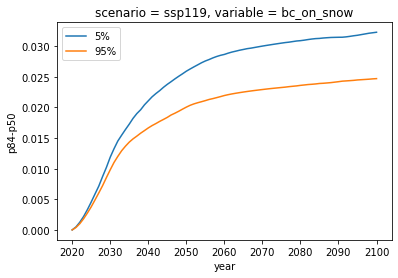

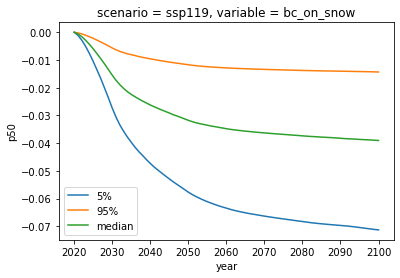

In [7]:
v_sigma2_bot = 'p16-p50'
v_sigma2_top = 'p84-p50'
np.abs(ds_unc[v_sigma2_bot]).sel(scenario='ssp119', variable=bc_on_snow).plot(label='5%')
np.abs(ds_unc[v_sigma2_top]).sel(scenario='ssp119', variable=bc_on_snow).plot(label='95%')
plt.legend()
plt.show()

v_sigma2_bot = 'p16'
v_sigma2_top = 'p84'
v_med = 'p50'
ds_unc[v_sigma2_bot].sel(scenario='ssp119', variable=bc_on_snow).plot(label='5%')
ds_unc[v_sigma2_top].sel(scenario='ssp119', variable=bc_on_snow).plot(label='95%')
ds_unc[v_med].sel(scenario='ssp119', variable=bc_on_snow).plot(label='median')
plt.legend()
plt.show()

### Calculate new distribution of the sum of aerosol + BC on snow, and estimate 5th and 95th percentile:

Estimate sigma from percentiles

In [8]:
p05 = 'p05'
p95 = 'p95'
p16 = 'p16'

p84 = 'p84'
median = 'p50'
es_sig = 'estimated_sigma'
es_median = 'estimated_median'
ds_unc[es_sig] = np.abs((ds_unc[p16] - ds_unc[p84]) / 2)

Compute sigma for sum: 

In [9]:
ds_bc_snow = ds_unc.sel(variable=bc_on_snow)
ds_aero_tot = ds_unc.sel(variable=aero_tot)
sigma_sum = np.sqrt(ds_bc_snow[es_sig] ** 2 + ds_aero_tot[es_sig] ** 2)
median_sum = ds_bc_snow[median] + ds_aero_tot[median]
_coords = ds_bc_snow.coords
_coords['variable'] = [aero_tot_wbc]
ds_sum = xr.Dataset(coords=_coords)  # {'variable':[aero_tot_wbc]})
# sig_bc_snow.coords)
ds_sum

<xarray.Dataset>
Dimensions:   (year: 81, scenario: 11, variable: 1)
Coordinates:
  * year      (year) int64 2020 2021 2022 2023 2024 ... 2096 2097 2098 2099 2100
  * scenario  (scenario) object 'ssp119' 'ssp126' 'ssp245' ... 'ssp434' 'ssp460'
  * variable  (variable) <U26 'aerosol-total-with_bc-snow'
Data variables:
    *empty*

Estimate percentiles for new distribution (assumed normal): 

In [10]:
from scipy.stats import norm

di = norm(loc=median_sum, scale=sigma_sum)

ds_sum[p05] = xr.DataArray(di.ppf(0.05), coords=ds_bc_snow[p05].coords)
ds_sum[p95] = xr.DataArray(di.ppf(0.95), coords=ds_bc_snow[p05].coords)
ds_sum[p16] = xr.DataArray(di.ppf(0.16), coords=ds_bc_snow[p05].coords)
ds_sum[p84] = xr.DataArray(di.ppf(0.84), coords=ds_bc_snow[p05].coords)
ds_sum[median] = xr.DataArray(di.ppf(0.50), coords=ds_bc_snow[p05].coords)

/Users/sarablichner/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/sarablichner/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [11]:
for v in [p05, p16, p84, p95, median]:
    ds_sum[f'{v}-{median}'] = ds_sum[v] - ds_sum[median]

### Plot result: 

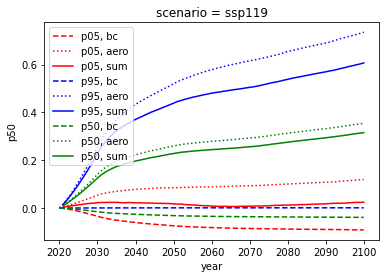

In [12]:
cols = {p05: 'r', p95: 'b', median: 'g'}
for c in [p05, p95, median]:
    ds_bc_snow[c].sel(scenario='ssp119').plot(c=cols[c], label=c + ', bc', linestyle='dashed')
    ds_aero_tot[c].sel(scenario='ssp119').plot(c=cols[c], label=c + ', aero', linestyle='dotted')
    ds_sum[c].sel(scenario='ssp119').plot(c=cols[c], linestyle='solid', label=c + ', sum')

# ds_aero_tot[p95].sel(scenario='ssp119').plot()
# ds_aero_tot[median].sel(scenario='ssp119').plot()
plt.legend()
plt.show()

### Write to netcdf

In [13]:
# noinspection PyDeprecation
ds_unc_upd = xr.concat([ds_unc.drop([es_sig]), ds_sum], dim='variable')
ds_unc_upd.variable
ds_unc_upd.to_netcdf(PATH_UNCERT_DT_OUTPUT)

## HFCs
The uncertainty estimates for temperature change output from FaIR contains more HFCs than those which are considered short lived. In the final figures we exclude some HFCs for this reason, and thus we also scale the uncertainties with the change in the magnitude of the total sum. 


In [14]:
# excluded_HFCs = ['HFC-23','HFC-125','HFC-143a','HFC-227ea','HFC-236fa']
excluded_HFCs = ['HFC-23', 'HFC-236fa']  # 'HFC-125','HFC-227ea','HFC-143a',

HFCs ordered by lifetime: 

In [15]:
ordered_lifetime_ls = [
    'HFC-152a',
    'HFC-32',
    'HFC-245fa',
    'HFC-365mfc',
    'HFC-134a',
    'HFC-43-10mee',
    'HFC-125',
    'HFC-227ea',
    'HFC-143a',
    'HFC-236fa',
    'HFC-23',
]

hfcs_tau = {
    'HFC-152a': 1.6,
    'HFC-32': 5.4,
    'HFC-245fa': 7.9,
    'HFC-365mfc': 8.9,
    'HFC-134a': 14.0,
    'HFC-43-10mee': 17.0,
    'HFC-125': 30.0,
    'HFC-227ea': 36.0,
    'HFC-143a': 51.0,
    'HFC-236fa': 213.0,
    'HFC-23': 228,
}

In [16]:
name_deltaT = 'Delta T'

### Load data

Open dataset:

In [17]:
ds_DT = xr.open_dataset(PATH_DT_INPUT)
ds_DT_minor = xr.open_dataset(PATH_DT_INPUT_minor)

# hfc Delta T
hfc_dT = ds_DT_minor[name_deltaT].sel(percentile='recommendation')

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html

In [ ]:
hfc_dT

Extract HFCs in file

### Compute ratio of sum of short lived HFCs and all HFCs: 

In [ ]:
ls = list(ds_DT_minor['variable'].values)
# chocose only those with HFC in them
vars_HFCs = [v for v in ls if 'HFC-' in v]

vars_HFCs

List of HFCs without the excluded ones:

In [ ]:
final_HFC_vars = [hfc for hfc in vars_HFCs if hfc not in excluded_HFCs]

final_HFC_vars

Sum of only short lived HFCs (excluding the longer lived ones):  

In [ ]:
hfs_sum_exclusive = hfc_dT.sel(variable=final_HFC_vars).sum('variable')

Sum with all HFCs: 

In [ ]:
hfs_sum_all = hfc_dT.sel(variable=vars_HFCs).sum('variable')

Ratio between sum of short lived and total: 

In [ ]:
rat = hfs_sum_exclusive / hfs_sum_all

### Plots:

#### Plot of ratio between short lived and total sum of HFCs over time:

In [ ]:
for scn in hfs_sum_all['scenario'].values:
    rat.sel(scenario=scn, year=slice(2020, 2100)).plot(label=scn)
    # hfs_sum_all.sel(scenario=scn).plot(label=scn)
    # hfs_sum_exclusive.sel(scenario=scn).plot(label=scn)

plt.legend()
plt.show()

#### Plot of temperature change over time for each HFC in example scenario

In [ ]:
for hf in ordered_lifetime_ls:
    hfc_dT.sel(variable=hf, scenario='ssp334', year=slice(2000, 2100)).plot(label=hf + ', %s' % hfcs_tau[hf])
plt.legend()
plt.show()

#### Plot of 95th percentile minus median for origial

In [ ]:
_da = ds_unc_upd['p95-p50'].sel(variable='HFCs')
for scn in _da['scenario'].values:
    _da.sel(scenario=scn).plot()
plt.show()

### Scale uncertainty in sum of HFCs by ratio between only short lived HFCs and all:

Copy input:

In [ ]:
ds_unc_upd2 = ds_unc_upd.copy(deep=True)

Update values of uncertainty of HFCs by scaling the difference between percentile and median according to the change in total HFCs: 

In [ ]:
v = 'p05-p50'
_tmp = (ds_unc_upd2[v]).loc[{'variable': 'HFCs'}] * rat
ds_unc_upd2[v].loc[{'variable': 'HFCs'}] = _tmp

In [ ]:
v = 'p95-p50'
_tmp = (ds_unc_upd2[v]).loc[{'variable': 'HFCs'}] * rat
ds_unc_upd2[v].loc[{'variable': 'HFCs'}] = _tmp

In [ ]:
ds_unc_upd2[v].sel(scenario='ssp585', variable='HFCs').plot()

ds_unc_upd[v].sel(scenario='ssp585', variable='HFCs').plot()

### Write to netcdf:

In [ ]:
ds_unc_upd2.to_netcdf(PATH_UNCERT_DT_OUTPUT)

In [ ]:
print(PATH_UNCERT_DT_OUTPUT)